In [13]:
import GPy
import tensorflow as tf
from gpflow.kernels import Kernel, Linear, RBF
import numpy as np
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
tfd = tfp.distributions

In [15]:
def stabilise(K: tf.Tensor, factor: float = 1e-6):
    return K + tf.eye(K.shape[0], dtype=tf.float64) * factor


def simulate(X: np.ndarray, k: Kernel, noise: float = 0.1):
    """
    Simulate from a GP. Assumes a zero-mean function, although extensions are straightfoward.
    """
    n = X.shape[0]
    sigma = stabilise(k.K(X))
    L = tf.linalg.cholesky(sigma)
    mu = tf.zeros(n, dtype=tf.float64)
    return tf.transpose(tfd.MultivariateNormalTriL(mu, L).sample(1)).numpy()

In [20]:
n_child = 3
n = 100
xlims = (-5.0, 5)
X_vals = np.tile(np.linspace(xlims[0], xlims[1], n), n_child).reshape(-1, 1)
X_idx = np.repeat(np.arange(n_child).astype(int), n).reshape(-1, 1)
X = np.hstack((X_vals, X_idx))
Y = np.vstack(
    [
        simulate(
            np.sort(np.random.uniform(xlims[0], xlims[1], n)).reshape(-1, 1),
            Linear(variance=l + 0.2) * RBF(lengthscales=0.2 * l + 0.3),
        )
        for l in np.arange(n_child)
    ]
)

In [25]:
#construct a hierarchical GPy kernel. 
kern_upper = GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=2.0, active_dims=[0], name='upper')
kern_lower = GPy.kern.RBF(input_dim=1, variance=0.1, lengthscale=4.0, active_dims=[0], name='lower')
k_hierarchy = GPy.kern.Hierarchical(kernels=[kern_upper, kern_lower])

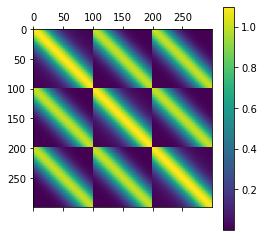

In [26]:
plt.matshow(k_hierarchy.K(X), cmap='viridis'); plt.colorbar()